In [1]:
import pymc3 as pm
import theano as TT
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Seed the rng for exact reproducible results
seed = 68492
np.random.seed(seed)



Text(0, 0.5, 'Frequencies')

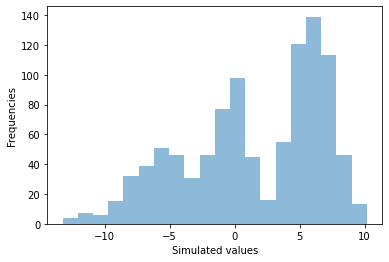

In [2]:
## Generate data with K components.
# Means, standard deviations, proportions
mus = [ 0, 6,-5]
sigmas = [ 1, 1.5, 3]
ps = [.2, .5,.3]
# Total amount of data
N = 1000
# Stack data into a single array
y = np.hstack([np.random.normal(mus[0], sigmas[0], int(ps[0]*N)),
np.random.normal(mus[1], sigmas[1], int(ps[1]*N)),
np.random.normal(mus[2], sigmas[2], int(ps[2]*N))])
## Plot the data as a histogram
plt.hist(y, bins=20, alpha=0.5)
# Add axes labels
plt.xlabel('Simulated values')
plt.ylabel('Frequencies')

In [3]:
## Build model
gmm = pm.Model()
# Specify number of groups
K = 3
with gmm:
    # Prior over z
    p = pm.Dirichlet('p', a=np.array([1.]*K))

    # z is the component that the data point is being sampled from.
    # Since we have N data points, z should be a vector with N elements.
    z = pm.Categorical('z', p=p, shape=N)
    # Prior over the component means and standard deviations
    mu = pm.Normal('mu', mu=0., sd=10., shape=K)
    sigma = pm.HalfCauchy('sigma', beta=1., shape=K)
    # Specify the likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=y)


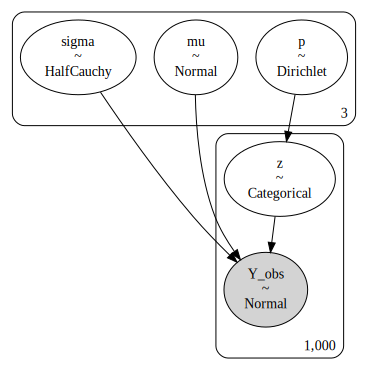

In [4]:
pm.model_graph.model_to_graphviz(gmm)

In [5]:
## Run sampler
with gmm:
    # Specify the sampling algorithms to use
    #map_estimate = pm.find_MAP()
    step1 = pm.NUTS(vars=[p, mu, sigma])
    step2 = pm.CategoricalGibbsMetropolis(vars=[z])

    # Start the sampler!
    trace = pm.sample(draws=500,
                        #nchains=4,
                        step=[step1, step2],
                        random_seed=seed)

<ipython-input-5-bee9d7329c55>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=500,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, mu, p]
>CategoricalGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 214 seconds.
/home/markus/.local/lib/python3.9/site-packages/arviz/stats/diagnostics.py:560: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-6-6bb70230e16a>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=True)
/home/markus/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

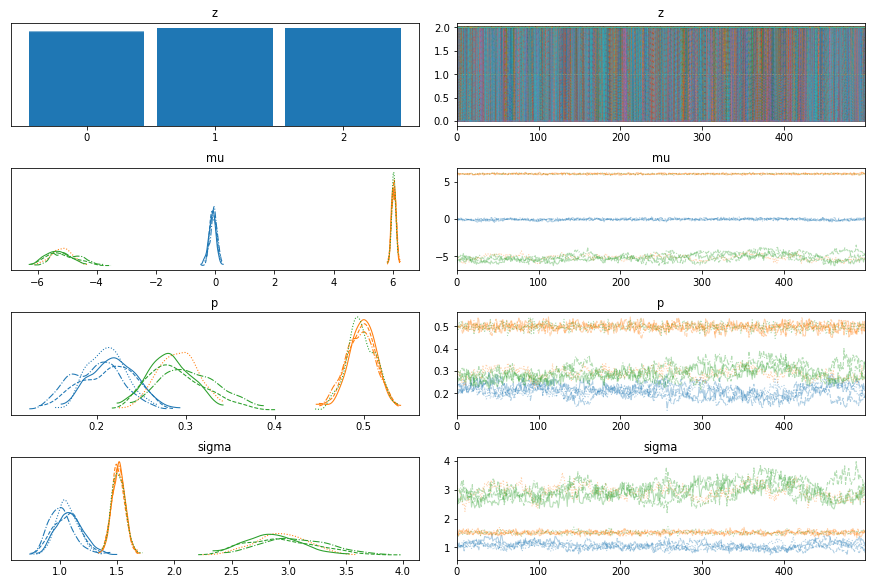

In [6]:
pm.traceplot(trace, compact=True)

In [7]:
## Build model
gtemp = 0.5 

gmm2 = pm.Model()
# Specify number of groups
K = 3
with gmm2:
    # Prior over z
    p = pm.Dirichlet('p', a=np.array([1.,1.,1.]))
    #lam = pm.Exponential('lam', lam=1, shape=(K,)) 
    #components = pm.Poisson.dist(mu=lam, shape=(K,))
    
    # Prior over the component means and standard deviations
    mu = pm.Normal('mu', mu=0., sd=10., shape=(K,))
    sigma = pm.HalfCauchy('sigma', beta=1., shape=(K,))
    
    # Specify a random variable (caveat: Mixture doesn't take distributions, but random variables)
    components = pm.Normal.dist(mu=mu, sigma=sigma, shape=(K,))
    
    
    X = pm.Mixture('Y_obs', w=p, comp_dists=components, observed=y)


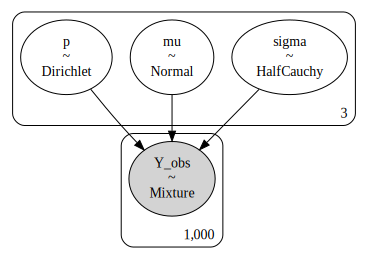

In [8]:
pm.model_graph.model_to_graphviz(gmm2)

In [9]:
with gmm2:
    # Start the sampler!
    trace = pm.sample(draws=500,
                      random_seed=seed)
    

<ipython-input-9-d46a254d1ded>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=500,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu, p]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-10-6bb70230e16a>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=True)
/home/markus/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

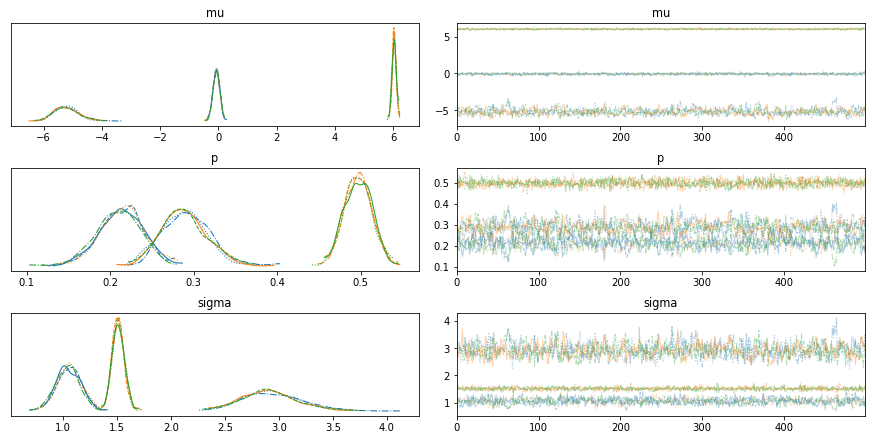

In [10]:
pm.traceplot(trace, compact=True)

In [11]:
with gmm2:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval,  # callable that returns std
    )

## Run advi
with gmm2:
    
    mean_field = advi.fit(20000, callbacks=[tracker])

Finished [100%]: Average Loss = 3,104.2


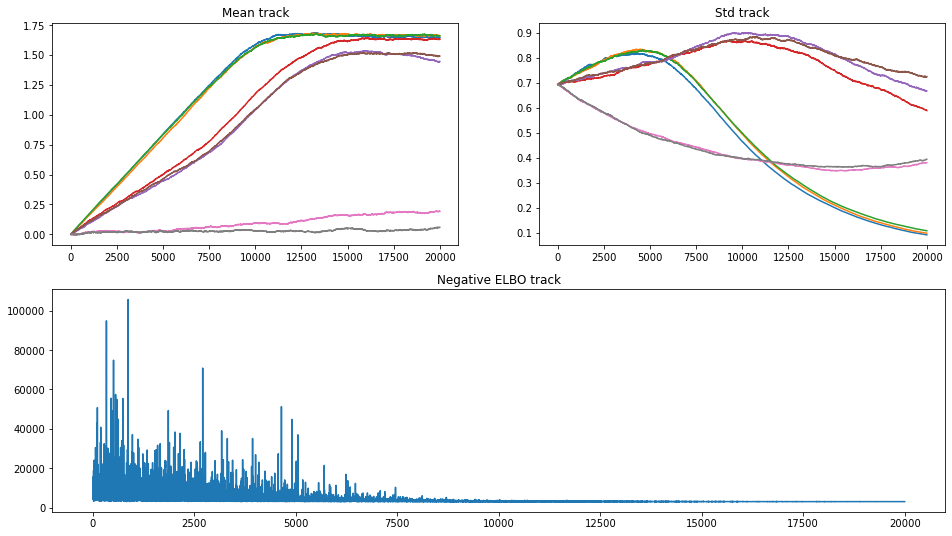

In [12]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

/home/markus/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


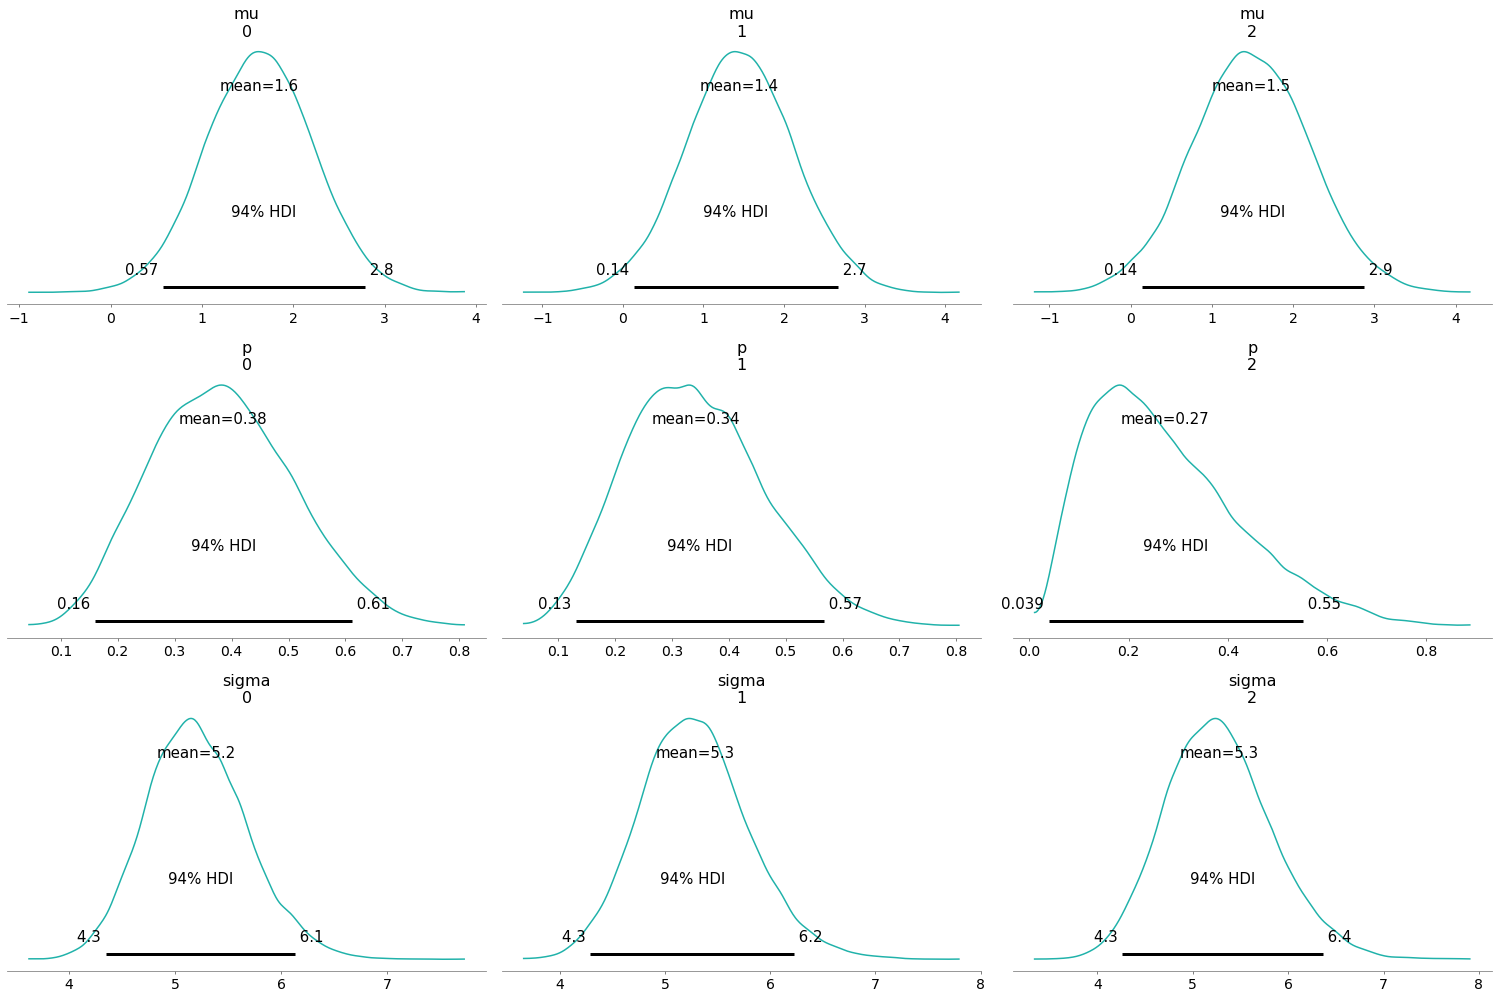

In [13]:
az.plot_posterior(mean_field.sample(20000), color="LightSeaGreen");

### ADVI doesn't work at all 

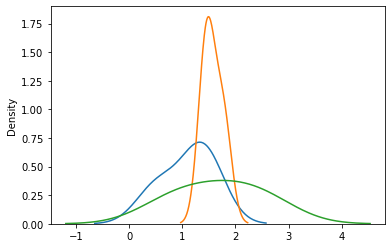

In [14]:
#ax = sns.kdeplot(trace["x"], label="NUTS")
sns.kdeplot(mean_field.sample(20000)["mu"][0], label="ADVI")
sns.kdeplot(mean_field.sample(20000)["mu"][1], label="ADVI")
sns.kdeplot(mean_field.sample(20000)["mu"][2], label="ADVI");

### Stein Variational Gradient Descent doesn't work, too


Compare with the statement from the person that implemented SVGD for pyro

https://forum.pyro.ai/t/stein-variational-inference-a-simple-example/3038


See also this paper [Blindness of score-based methods to isolated components and mixing proportions](https://arxiv.org/abs/2008.10087)

In [50]:
svgd_num = 500
with gmm2:
    svgd = pm.SVGD(n_particles=150, jitter=2, temperature=2.5) # play with hyperparms a bit
    tracker = pm.callbacks.Tracker(
        mean=svgd.approx.mean.eval,  # callable that returns mean
        std=svgd.approx.std.eval,  # callable that returns std
    )


## Run svgd
with gmm2:
    mean_field2 = svgd.fit(svgd_num, callbacks=[tracker])

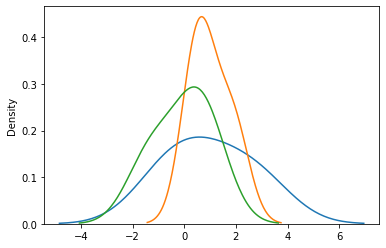

In [48]:
#ax = sns.kdeplot(trace["x"], label="NUTS")
sns.kdeplot(mean_field2.sample(svgd_num)["mu"][0], label="SVGD")
sns.kdeplot(mean_field2.sample(svgd_num)["mu"][1], label="SVGD")
sns.kdeplot(mean_field2.sample(svgd_num)["mu"][2], label="SVGD");

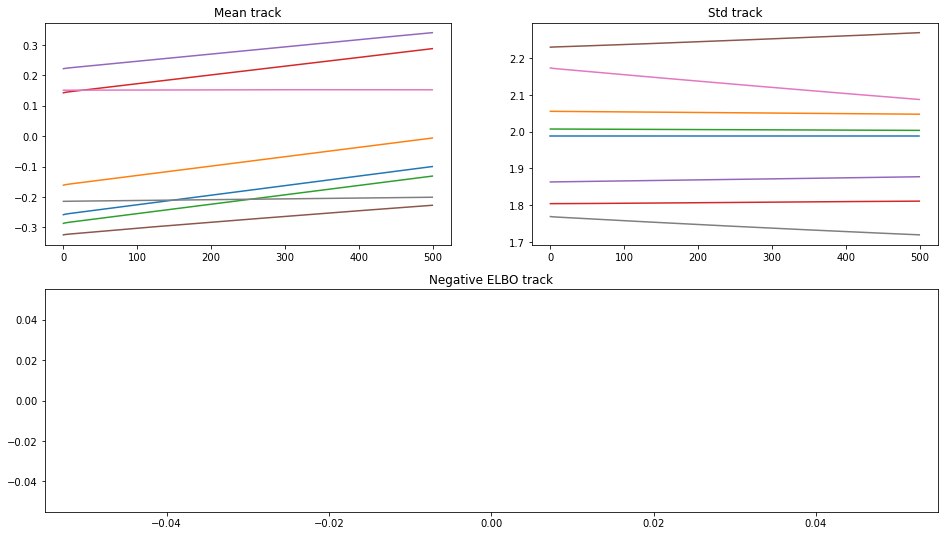

In [49]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(svgd.hist)
hist_ax.set_title("Negative ELBO track");

/home/markus/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


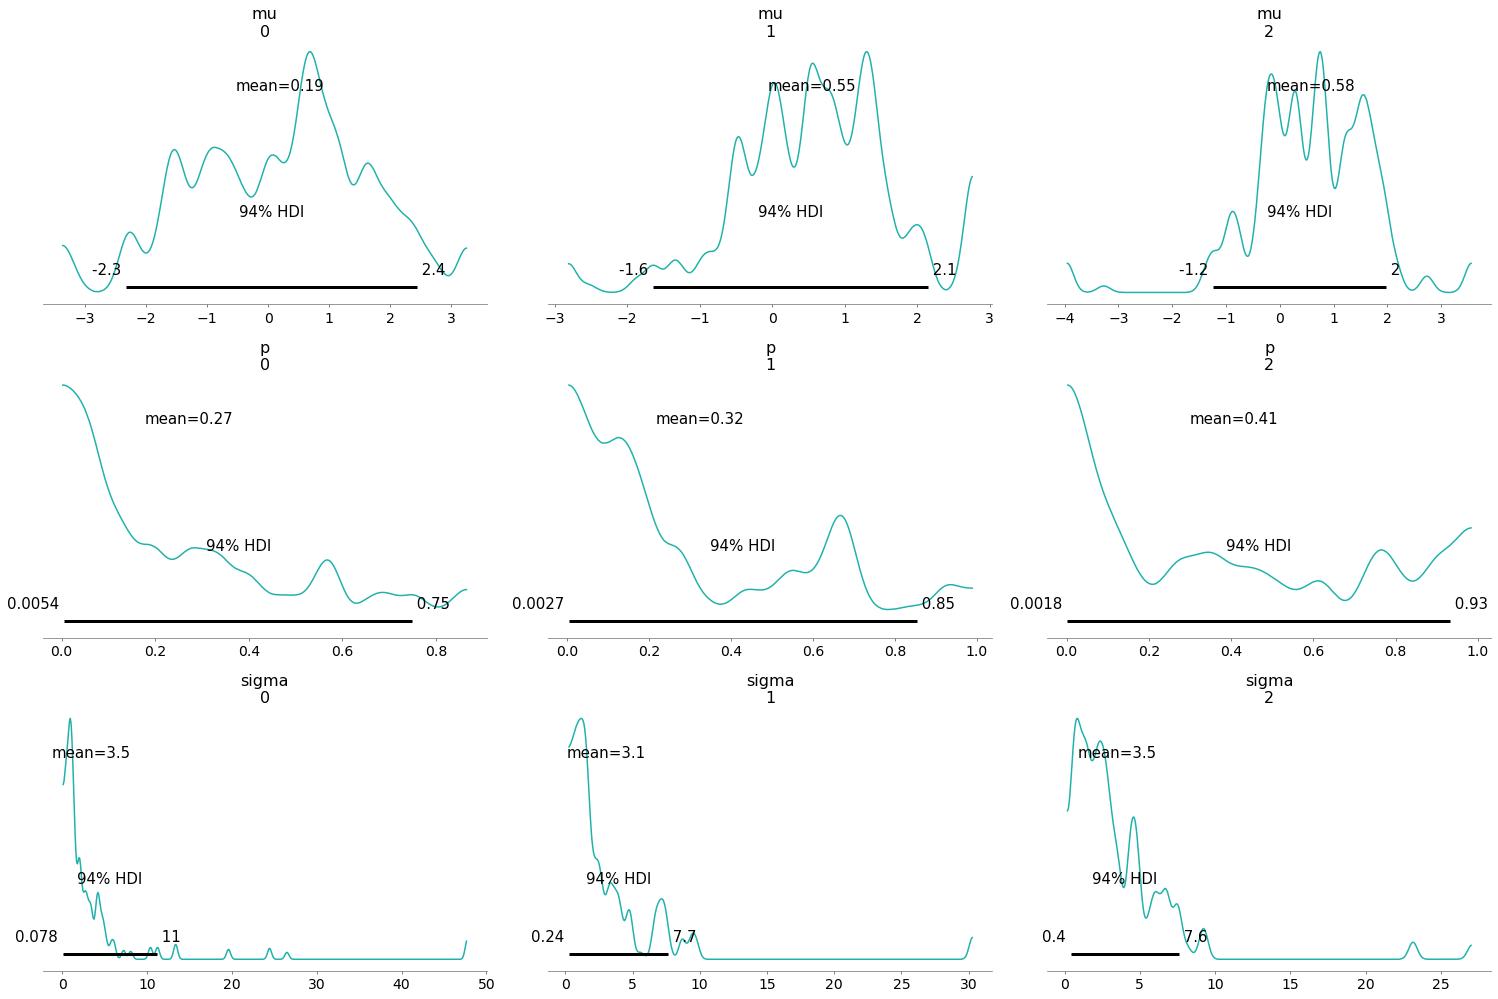

In [200]:
az.plot_posterior(mean_field2.sample(1000), color="LightSeaGreen");

<AxesSubplot:ylabel='Density'>

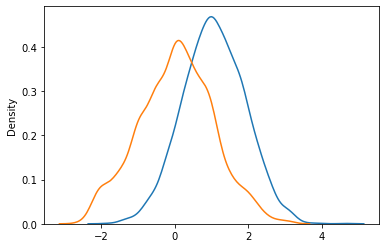

In [165]:
#ax = sns.kdeplot(trace["x"], label="NUTS")
sns.kdeplot(mean_field.sample(1000)["mu"].flatten(), label="ADVI")
sns.kdeplot(mean_field2.sample(1000)["mu"].flatten(), label="SVGD")

In [12]:
l = [ 1, 0 -1, 0, 1, 0, 0, 0 -1, 1, 0, 0, 0 -1, 0, 0, 1, 0 -1, 0, 0, 1, 0, 0
, 0, 0 -1, 0, 1, 0 -1, 0, 1, 0 -1, 1, 0, 0, 0, 0 -1, 1, 0, 0, 0 -1, 1, 0
, 0, 0 -1, 1 -1, 1, 0 -1, 0, 1, 0 -1, 1, 0 -1, 0, 0, 0, 1, 0, 0 -1, 1 -1
, 1, 0, 0, 0 -1, 1, 0, 0, 0, 0 -1, 1, 0, 0 -1, 0, 0, 1 -1, 1, 0, 0 -1, 0
, 1, 0 -1, 1, 0, 0, 0, 0, 0 -1, 0, 1 -1, 1, 0, 0 -1, 1, 0, 0, 0, 0, 0 -1
, 0, 1, 0, 0, 0, 0, 0 -1, 1, 0 -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0 -1, 1
 -1, 1, 0, 0, 0 -1, 1, 0, 0, 0, 0, 0, 0, 0, 0 -1, 0, 1 -1, 1 -1, 1 -1, 0
, 1, 0 -1, 0, 1, 0, 0, 0 -1, 0, 1, 0, 0, 0, 0 -1, 0, 0, 1 -1, 1 -1, 0, 1
, 0 -1, 0, 0, 1, 0, 0 -1, 1 -1, 1 -1, 1 -1, 0, 0, 0, 1 -1, 0, 1, 0 -1, 1
 -1, 1 -1, 1, 0, 0, 0 -1, 0, 1, 0, 0 -1, 1, 0, 0, 0 -1, 1, 0, 0, 0, 0, 0
, 0, 0, 0, 0 -1, 1, 0, 0, 0, 0 -1, 1 -1, 1, 0, 0, 0, 0, 0, 0 -1, 1, 0, 0
 -1, 1, 0, 0, 0 -1, 0, 0, 1 -1, 1, 0 -1, 0, 0, 0, 1, 0 -1, 0, 1, 0, 0 -1
, 1, 0, 0, 0 -1, 0, 1, 0, 0 -1, 1 -1, 1, 0 -1, 0, 0, 0, 0, 1 -1, 1, 0 -1
, 1, 0, 0 -1, 1, 0 -1, 1, 0 -1, 1 -1, 0, 0, 0, 1, 0 -1, 0, 0, 1, 0, 0, 0
, 0 -1, 1 -1, 1 -1, 1, 0 -1, 1, 0, 0 -1, 1, 0, 0, 0 -1, 0, 1, 0, 0, 0, 0
, 0, 0, 0, 0, 0, 0, 0 -1, 0, 1, 0, 0, 0 -1, 1, 0 -1, 1, 0, 0, 0, 0 -1, 1
, 0, 0 -1, 0, 1, 0 -1, 0, 1 -1, 1, 0 -1, 1, 0, 0 -1, 1, 0, 0, 0, 0, 0, 0
, 0, 0 -1, 0, 0, 1, 0, 0 -1, 0, 1, 0 -1, 1 -1, 1, 0, 0, 0, 0, 0 -1, 1, 0
, 0 -1, 1 -1, 1, 0 -1, 0, 1 -1, 0, 1 -1, 0, 0, 1 -1, 0, 0, 0, 0, 0, 1, 0
, 0, 0, 0, 0 -1, 1 -1, 1 -1, 1, 0 -1, 1, 0 -1, 0, 0, 0, 1, 0, 0, 0 -1, 1
, 0, 0 -1, 1 -1, 0, 1 -1, 0, 1, 0, 0, 0, 0, 0, 0 -1, 1 -1, 0, 1 -1, 0, 1
 -1, 1, 0, 0 -1, 1, 0 -1, 0, 0, 1 -1, 1, 0 -1, 1, 0, 0 -1, 1 -1, 0, 1, 0
, 0 -1, 0, 1, 0 -1, 1 -1, 1, 0 -1, 1, 0, 0 -1, 0, 1, 0, 0, 0, 0, 0, 0 -1
, 1, 0 -1, 0, 1, 0, 0 -1, 1, 0, 0 -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 -1, 1
 -1, 1, 0, 0 -1, 1, 0, 0 -1, 1, 0 -1, 0, 1, 0 -1, 1 -1, 1, 0 -1, 0, 0, 0]

In [13]:
arr = np.array(l)

In [59]:
arr = np.array([3, 1, 4, 2, 3, 3, 
       2, 1, 2, 2, 3, 3,
       2, 3, 4, 1, 1, 4,
       2, 1, 3, 3, 1, 2])

In [60]:
arr.shape

(24,)

In [61]:
#arr2 = np.lib.stride_tricks.sliding_window_view(arr, 2)
filtsize=2

arr2 = np.lib.stride_tricks.as_strided(arr, shape=(arr.size,filtsize), strides=(arr.itemsize, arr.itemsize))

#arr2 = np.lib.stride_tricks.as_strided(arr, shape=(23,2), strides=(8,8))

In [62]:
arr2

array([[  3,   1],
       [  1,   4],
       [  4,   2],
       [  2,   3],
       [  3,   3],
       [  3,   2],
       [  2,   1],
       [  1,   2],
       [  2,   2],
       [  2,   3],
       [  3,   3],
       [  3,   2],
       [  2,   3],
       [  3,   4],
       [  4,   1],
       [  1,   1],
       [  1,   4],
       [  4,   2],
       [  2,   1],
       [  1,   3],
       [  3,   3],
       [  3,   1],
       [  1,   2],
       [  2, 208]])

In [63]:
hpairs = (arr2[:, :-1] == arr2[:, 1:])

In [64]:
hpairs.shape

(24, 1)

In [65]:
arr[hpairs.flatten()] = 0

In [66]:
arr

array([3, 1, 4, 2, 0, 3, 2, 1, 0, 2, 0, 3, 2, 3, 4, 0, 1, 4, 2, 1, 0, 3,
       1, 2])

In [79]:
(arr == 3).astype(int)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

In [71]:
import pandas as pd
from pandas import Timestamp

In [77]:
for vl in valueList:
    print(vl)
    break

('time_travelling_too_fast', '73000', Timestamp('2021-12-02 00:00:00', freq='H'), None, 2700.0, None, None)
